In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import pandas as pd
from datetime import datetime, date
import time
import warnings
import numpy as np
from numpy import newaxis

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout,Flatten
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import SimpleRNN
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD

Using TensorFlow backend.


# - S&P 500 の過去データを米国ヤフーからダウンロード　-------------------------------

In [2]:
#Step 1 Load Data
tsd0 = web.DataReader("SPY","yahoo","1990/1/1")
tsd = tsd0.Close.values

In [3]:
def prepare_data(data, time_window,shuffling):
    data_div = []
    for index in range(len(data) - time_window-1):#データをdata_lengthの長さに分割する
        data_div.append(data[index: index + time_window+1])
    n_data = []
    for w in data_div:
        n_window = [((float(ww) / float(w[0])-1)) for ww in w]#価格データを初期価格で基準化しリターンの形に変更している。
        n_data.append(n_window)
    data_div = np.array(n_data)

    row = round(0.9 * data_div.shape[0])#最初の90%を訓練データに、後の10%をテストデータに分割している。
    train = data_div[:int(row), :]#
    if shuffling:
        np.random.shuffle(train)
    x_train = train[:, :-1]#train(全データ数、time_window数)
    y_train = train[:, -1]
    x_test = data_div[int(row):, :-1]#train(全データ数、time_window-1数)
    y_test = data_div[int(row):, -1]#train(全データ数、1)
    print(x_train.shape[0],x_train.shape[1])
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

In [4]:
#Step 2 
time_window=10
pred_window=1
X_train, Y_train, X_test, Y_test = prepare_data(tsd, time_window,True)
print('no. of all data',len(tsd))
print('no. of train data X',len(X_train),'y',len(Y_train))
print('no. of test data X',len(X_test),'y', len(Y_test))
print(X_train.shape,Y_train.shape)

5612 10
no. of all data 6247
no. of train data X 5612 y 5612
no. of test data X 624 y 624
(5612, 10, 1) (5612,)


In [5]:
noize=0
for data,d2 in zip(X_train,Y_train):
    noize+=(data[9]-d2)**2
print(noize/len(Y_train))

[ 0.0001365]


# 多層パーセプトロン (MLP) 


loss 0.000133966591106
average val_loss 0.00010485690928
40
0:00:08.072482


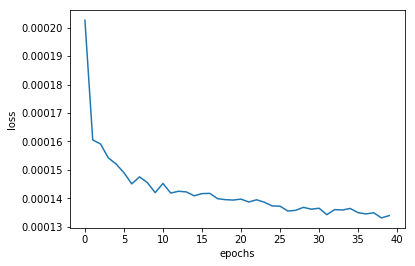

In [6]:
start_time=datetime.now()
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(time_window,)))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse',optimizer='rmsprop')

XX_train=X_train.reshape(X_train.shape[0],time_window)
XX_test=X_test.reshape(X_test.shape[0],time_window)
epochs=40
results=model.fit(XX_train, Y_train,epochs=epochs,batch_size=30,verbose=0, validation_data=(XX_test, Y_test))
loss=results.history['loss']
plt.plot(range(epochs),loss)
plt.xlabel('epochs')
plt.ylabel('loss')
print()
print('loss',loss[-1])
val_loss=results.history['val_loss']
print('average val_loss',np.average(val_loss))
print(len(val_loss))
print(datetime.now()-start_time)

# VGG-like convnet:

#  LSTMを用いた系列データ分析:


In [7]:
model = Sequential()
model.add(LSTM(input_shape=(None,1),units=128,return_sequences=False))
model.add(Dense(units=1))
model.add(Activation('linear'))
model.compile(loss='mse', optimizer='rmsprop')
#model.summary()


loss 0.000146631424556
average val_loss 6.99997121093e-05
0:00:28.667530


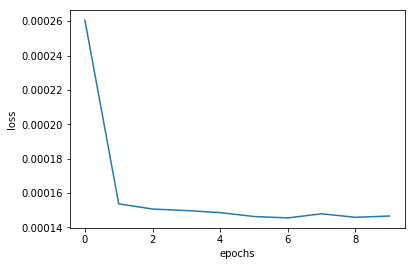

In [8]:
start_time=datetime.now()
epochs=10
results=model.fit(X_train, Y_train, batch_size=20, epochs=epochs,verbose=0,validation_data=(X_test, Y_test))
loss=results.history['loss']
plt.plot(range(epochs),loss)
plt.xlabel('epochs')
plt.ylabel('loss')
print()
print('loss',loss[-1])
val_loss=results.history['val_loss']
print('average val_loss',np.average(val_loss))
print(datetime.now()-start_time)

# 1D Convolutionを用いた系列データ分析:


In [9]:
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(time_window,1)))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Conv1D(32, 3, activation='relu'))
model.add(Conv1D(32, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation='linear'))
model.compile(loss='mse',optimizer='rmsprop')


loss 0.000158362479753
average val_loss 0.000106958085027
0:00:13.515153


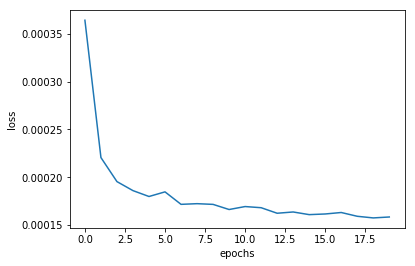

In [10]:
start_time=datetime.now()
epochs=20
results=model.fit(X_train, Y_train, batch_size=20, epochs=epochs,verbose=0,validation_data=(X_test, Y_test))
loss=results.history['loss']
plt.plot(range(epochs),loss)
plt.xlabel('epochs')
plt.ylabel('loss')
print()
print('loss',loss[-1])
val_loss=results.history['val_loss']
print('average val_loss',np.average(val_loss))
print(datetime.now()-start_time)